In [1]:
#addprocs(4);
using DistributedArrays
@everywhere using DistributedArrays
using ForwardDiff
@everywhere using ForwardDiff
using StaticArrays
@everywhere using StaticArrays
@everywhere include("Stencil.jl")
@everywhere include("stencilgmres.jl")
@everywhere include("reservoirfunc.jl")
@everywhere include("distributed.jl")
@everywhere include("res3d.jl")
@everywhere include("preconditioning.jl")
using BenchmarkTools

In [2]:
permdata = open("spe_perm.dat")
phidata  = open("spe_phi.dat")
raw1 = readdlm(phidata)
raw2 = readdlm(permdata)
close(permdata)
close(phidata)
porosity = reshape(raw1', 60, 220, 85)
lineperm = reshape(raw2', 3366000, 1)
kx = reshape(lineperm[1:1122000]', 60, 220, 85)
ky = reshape(lineperm[1122001:2244000]', 60, 220, 85)
kz = reshape(lineperm[2244001:end]', 60, 220, 85)
savepor = copy(porosity)
saveper = (kx.+ky.+kz)./3
## Porosity pre-processing
for id in eachindex(porosity)
    if abs(porosity[id])<1e-3
        porosity[id] = 0.2
        kx[id], ky[id], kz[id] = 1e-10, 1e-10, 1e-10
    end
end
kraw = [SVector{3,Float64}([kx[i,j,k], ky[i,j,k], kz[i,j,k]]) for i in 1:60, j in 1:220, k in 1:85];

In [24]:
Nx = 40
Ny = 40
Nz = 40
offset = 1;

In [25]:
@everywhere p_ref = 14.7 
@everywhere C_r   = 3e-6
@everywhere ϕ_ref = 0.2
#=everywhere=# ϕ     = porosity[offset:(Nx+offset-1), offset:(Ny+offset-1), offset:(Nz+offset-1)]
@everywhere S_wc, S_or = 0.2, 0.2
@everywhere k_r_w(x)   = ((x-S_wc)/(1-S_wc-S_or))^2
@everywhere k_r_o(x)   = (1 - (x-S_wc)/(1-S_wc-S_or))^2
@everywhere p_cow(x)   = 0
@everywhere C_water    = 3e-6
@everywhere C_oil      = 3e-6
@everywhere ρ_water(p) = 64.0*exp(C_water*(p-p_ref)) 
@everywhere ρ_oil(p)   = 53.0*exp(C_oil*(p-p_ref))   
@everywhere μ_water = 0.3 # cp
@everywhere μ_oil   = 3.0 # cp

In [26]:
## 3d model
Lx = 1200
Ly = 2200
Lz = 170
Δt = 0.01
Tf = 2000.0
Δx = (fill(Lx/Nx, Nx, Ny, Nz))
Δy = (fill(Ly/Ny, Nx, Ny, Nz))
Δz = fill(Lz/Nz, Nx, Ny, Nz)
z  = fill(12000.0, Nx, Ny, Nz)
k = makegrid(kraw[(offset):(Nx+offset-1), offset:(Ny+offset-1), offset:(Nz+offset-1)],7)
model = Reservoirmodel(Δt, Tf, (Δx, Δy, Δz), z, k, p_ref, C_r, ϕ_ref, ϕ, 
                k_r_w, k_r_o, p_cow, C_water, C_oil, ρ_water, ρ_oil, μ_water, μ_oil);

In [27]:
## Porosity proportional control
Total = 5000.0
q = zeros(Nx, Ny, Nz, 2)
for i in (1,Nx), j in (1,Ny), k in 1:Nz
    q[i,j,k,2] = Total*(saveper[i,j,k]/sum(saveper[i,j,:]))/4
end
halfx, halfy = round(Int, Nx/2),round(Int, Ny/2)
for k in 1:Nz
    q[halfx,halfy,k,1] = -Total*(saveper[halfx,halfy,k]/sum(saveper[halfx,halfy,:]))
end 
#=## Constant rate well control
Total = 1000.0
q = zeros(Nx, Ny, Nz, 2)
for x in (1,Nx), y in (1,Ny), z in 1:Nz
    q[x, y, z, 1] = Total/4/Nz
end
for z in 1:Nz
    q[round(Int, Nx/2),round(Int, Ny/2),z,2] = -Total/Nz
end
q_d = distribute(q);=#

In [28]:
init       = [SVector{2,Float64}([6000.0,0.2]) for i in 1:Nx, j in 1:Ny, k in 1:Nz]
testgrid   = makegrid(init, 7);
g_guess   = testgrid;

In [29]:
S = getstencil(model, q, g_guess, testgrid)
res = getresidual(model, q, g_guess, testgrid);

In [30]:
psps = solveprec1(model, fill(q,2), testgrid, 2);

In [31]:
psps = solveprec1(model, fill(q,20), testgrid, 20, printt=true);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


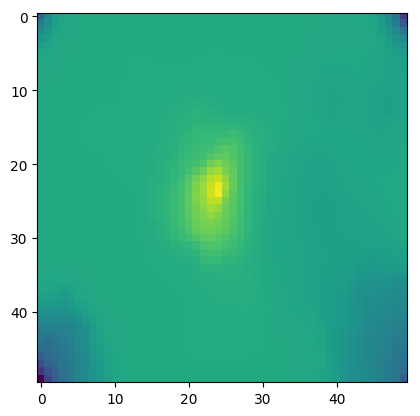

PyObject <matplotlib.image.AxesImage object at 0x146fa0d90>

In [22]:
imshow([psps[20][i,j,20][1] for i in 1:Nx, j in 1:Ny])

In [23]:
[psps[20][i,j,20][1] for i in 1:Nx, j in 1:Ny]

50×50 Array{Float64,2}:
 5963.31  5982.96  5993.7   5997.93  …  5992.37  5984.06  5970.42  5943.43
 5974.91  5985.82  5994.26  5997.9      5992.87  5985.5   5975.02  5957.37
 5982.88  5989.52  5995.58  5998.28     5994.83  5988.95  5981.0   5972.23
 5989.78  5993.94  5997.38  5998.88     5996.62  5992.62  5987.44  5982.79
 5994.56  5996.69  5998.3   5999.34     5997.14  5994.93  5991.51  5988.4 
 5997.19  5998.15  5998.97  5999.66  …  5996.99  5996.06  5993.74  5991.48
 5998.67  5999.05  5999.39  5999.78     5996.96  5996.38  5995.24  5993.78
 5999.1   5999.24  5999.57  5999.84     5996.89  5996.48  5995.91  5995.43
 5999.25  5999.39  5999.69  5999.88     5996.75  5996.37  5996.07  5995.95
 5999.43  5999.51  5999.77  5999.91     5996.47  5996.07  5996.01  5996.08
 5999.66  5999.72  5999.87  5999.94  …  5995.93  5995.64  5995.85  5996.09
 5999.83  5999.89  5999.93  5999.97     5995.21  5995.06  5995.74  5996.13
 5999.9   5999.94  5999.97  5999.99     5994.44  5994.32  5995.65  5996.23
 

In [35]:
result_g = stencilgmres(S, res, 100;ifprint=true,M=(t->precond_1(P,E,t)))[4]

1

9.659478136779173e-6

In [41]:
N = Nx*Ny*Nz
Nxy = Nx*Ny
A = spzeros(2N,2N)
b = zeros(2N)
bb = zeros(2N)
for i in 1:Nx, j in 1:Ny, k in 1:Nz
    nd = (k-1)*Nxy+(j-1)*Nx+i
    A[(2*nd-1):2*nd, (2*nd-1):2*nd] = S[i,j,k].value[4]
    if i!=1  A[(2*nd-1):2*nd, (2*nd-3):(2*nd-2)]           = S[i,j,k].value[1] end
    if j!=1  A[(2*nd-1):2*nd, (2*nd-2*Nx-1):(2*nd-2*Nx)]   = S[i,j,k].value[2] end  
    if k!=1  A[(2*nd-1):2*nd, (2*nd-2*Nxy-1):(2*nd-2*Nxy)] = S[i,j,k].value[3] end
    if k!=Nz A[(2*nd-1):2*nd, (2*nd+2*Nxy-1):(2*nd+2*Nxy)] = S[i,j,k].value[5] end
    if j!=Ny A[(2*nd-1):2*nd, (2*nd+2*Nx-1):(2*nd+2*Nx)]   = S[i,j,k].value[6] end
    if i!=Nx A[(2*nd-1):2*nd, (2*nd+1):(2*nd+2)]           = S[i,j,k].value[7] end
    b[(2*nd-1):(2*nd)] = res[i,j,k]
    bb[(2*nd-1):(2*nd)] = result_g[i,j,k]
    if (j==1)&&(k==1) print(i) end
end    
#ab = (A\b)

123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960

In [29]:
PrecondP = zeros(A)
for i in 1:size(A,1), j in 1:size(A,2)
    if abs(i-j)<3.5 PrecondP[i,j] = A[i,j] end
end
E = A-PrecondP
P_A = inv(inv(full(PrecondP))*(eye(A)-E*inv(full(PrecondP))));
P_A_inv = (inv(full(PrecondP))*eye(A)-E*inv(full(PrecondP)));

In [30]:
IterativeSolvers.gmres(A, b;log=true, restart = 100)

([0.0115155, -6.56368e-9, 1.50236e-5, -1.02709e-11, 2.06247e-8, -1.5587e-14, 3.39189e-11, -3.21048e-17, 4.13656e-14, -4.35804e-20  …  2.61436e-6, -5.12135e-11, 1.2998e-5, -1.60616e-10, 5.15291e-5, -7.022e-11, 0.000294822, -4.07073e-10, 0.0429689, -2.91515e-8], Not converged after 8192 iterations.)

In [31]:
IterativeSolvers.gmres(A, b; Pl=lufact!(full(P_A)),log=true,restart=100)

([0.0115504, -6.93026e-9, 1.54878e-5, -9.29268e-12, 2.23621e-8, -1.34173e-14, 4.10156e-11, -2.46094e-17, 5.79026e-14, -3.47416e-20  …  1.17908e-5, -7.0745e-12, 3.23859e-5, -1.94315e-11, 7.39067e-5, -4.4344e-11, 0.000349556, -2.09734e-10, 0.0440842, -2.64505e-8], Converged after 27 iterations.)

In [32]:
N = Nx*Ny*Nz
Nxy = Nx*Ny
stencilarray_P = Array{StencilPoint{typeof(@SMatrix(randn(2,2))),3,7},3}(Nx,Ny,Nz)
for i in 1:Nx, j in 1:Ny, k in 1:Nz
    temp = [@SMatrix(zeros(2,2)) for xxx in 1:7]
    nd = (k-1)*Nxy+(j-1)*Nx+i
    temp[4] = P_A_inv[(2*nd-1):2*nd, (2*nd-1):2*nd]
    if i!=1  temp[1] = SMatrix{2,2}(P_A_inv[(2*nd-1):2*nd, (2*nd-3):(2*nd-2)])           end
    if j!=1  temp[2] = SMatrix{2,2}(P_A_inv[(2*nd-1):2*nd, (2*nd-2*Nx-1):(2*nd-2*Nx)])   end  
    if k!=1  temp[3] = SMatrix{2,2}(P_A_inv[(2*nd-1):2*nd, (2*nd-2*Nxy-1):(2*nd-2*Nxy)]) end
    if k!=Nz temp[5] = SMatrix{2,2}(P_A_inv[(2*nd-1):2*nd, (2*nd+2*Nxy-1):(2*nd+2*Nxy)]) end
    if j!=Ny temp[6] = SMatrix{2,2}(P_A_inv[(2*nd-1):2*nd, (2*nd+2*Nx-1):(2*nd+2*Nx)])   end
    if i!=Nx temp[7] = SMatrix{2,2}(P_A_inv[(2*nd-1):2*nd, (2*nd+1):(2*nd+2)])           end  
    stencilarray_P[i,j,k] = StencilPoint{eltype(temp),3,7}(Tuple(temp))
end  
P_A_Stencil = Stencil{typeof(stencilarray_P[1,1,1].value[1]),3,7,typeof(stencilarray_P)}(stencilarray_P);

In [33]:
result_g2 = stencilgmres(S, res, 20;maxiter=100,ifprint=true, M = (t->P_A_Stencil*t),tol=1e-9)[1]

123456789101112131415161718192021222324252627

16×16×16 Grid{StaticArrays.SArray{Tuple{2},Float64,1,2},3,7,Array{StaticArrays.SArray{Tuple{2},Float64,1,2},3}}:
[:, :, 1] =
 [0.0115504, -6.93026e-9]     …  [0.0486194, -2.91719e-8]   
 [1.54878e-5, -9.29269e-12]      [0.000250807, -1.50485e-10]
 [2.23621e-8, -1.3403e-14]       [1.18658e-6, -7.11492e-13] 
 [4.10156e-11, -2.57871e-17]     [2.55198e-9, -1.52975e-15] 
 [5.79026e-14, -1.01312e-18]     [2.24175e-12, -4.52068e-19]
 [1.19567e-16, 2.49023e-19]   …  [1.25604e-15, 2.51088e-20] 
 [2.50101e-18, 4.67675e-19]      [1.61989e-17, 1.12865e-19] 
 [3.24755e-20, 4.93713e-20]      [6.9593e-15, 2.38987e-18]  
 [8.57212e-21, 2.89745e-19]      [1.78068e-12, 1.96307e-16] 
 [3.7637e-20, 3.74101e-21]       [2.59303e-10, -4.63816e-15]
 [2.4294e-17, -3.17708e-23]   …  [2.93724e-8, -6.23282e-15] 
 [1.87968e-14, -1.11333e-20]     [2.74296e-6, -2.09077e-12] 
 [5.18497e-11, -3.11096e-17]     [9.00098e-5, -5.35543e-11] 
 [1.1075e-7, -6.64498e-14]       [0.00163789, -9.82581e-10] 
 [7.5718e-5, -4.54308

In [34]:
N = Nx*Ny*Nz
Nxy = Nx*Ny
A = spzeros(2N,2N)
b = zeros(2N)
bb = zeros(2N)
bbb = zeros(2N)
for i in 1:Nx, j in 1:Ny, k in 1:Nz
    nd = (k-1)*Nxy+(j-1)*Nx+i
    A[(2*nd-1):2*nd, (2*nd-1):2*nd] = S[i,j,k].value[4]
    if i!=1  A[(2*nd-1):2*nd, (2*nd-3):(2*nd-2)]           = S[i,j,k].value[1] end
    if j!=1  A[(2*nd-1):2*nd, (2*nd-2*Nx-1):(2*nd-2*Nx)]   = S[i,j,k].value[2] end  
    if k!=1  A[(2*nd-1):2*nd, (2*nd-2*Nxy-1):(2*nd-2*Nxy)] = S[i,j,k].value[3] end
    if k!=Nz A[(2*nd-1):2*nd, (2*nd+2*Nxy-1):(2*nd+2*Nxy)] = S[i,j,k].value[5] end
    if j!=Ny A[(2*nd-1):2*nd, (2*nd+2*Nx-1):(2*nd+2*Nx)]   = S[i,j,k].value[6] end
    if i!=Nx A[(2*nd-1):2*nd, (2*nd+1):(2*nd+2)]           = S[i,j,k].value[7] end
    b[(2*nd-1):(2*nd)] = res[i,j,k]
    bb[(2*nd-1):(2*nd)] = result_g[i,j,k]
    bbb[(2*nd-1):(2*nd)] = result_g2[i,j,k]
    if (j==1)&&(k==1) print(i) end
end    
ab = (A\b)

12345678910111213141516

8192-element Array{Float64,1}:
  0.0115504  
 -6.93026e-9 
  1.54878e-5 
 -9.29268e-12
  2.23621e-8 
 -1.34173e-14
  4.10156e-11
 -2.46094e-17
  5.79026e-14
 -3.47416e-20
  1.19564e-16
 -7.17382e-23
  2.49444e-18
  ⋮          
  7.52614e-6 
 -4.51568e-12
  1.17909e-5 
 -7.07453e-12
  3.23859e-5 
 -1.94315e-11
  7.39067e-5 
 -4.4344e-11 
  0.000349556
 -2.09734e-10
  0.0440842  
 -2.64505e-8 

In [35]:
maximum(abs.(ab-bb))

2.270991796764079

In [36]:
maximum(abs.(ab-bbb))

0.00018114996381795025

In [37]:
norm(ab-bb), norm(ab-bbb)

(2.8959908930086975, 0.00033804160815213566)

In [43]:
SS

16×16×16 Array{StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7},3}:
[:, :, 1] =
 StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7}(([0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], [-12.7868 -2.13113e7; -42.4382 1.76485e7], [0.0 0.0; 0.000281267 0.0], [0.0 0.0; 0.0186915 0.0], [0.0 0.0; 0.0623274 0.0]))        …  StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7}(([0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0726078 0.0], [0.0 0.0; 0.0 0.0], [-18.6878 -3.11464e7; -62.3841 2.57931e7], [0.0 0.0; 0.00188046 0.0], [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.402621 0.0]))        
 StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7}(([0.0 0.0; 0.0623274 0.0], [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], [-11.1865 -1.86442e7; -37.219 1.54397e7], [0.0 0.0; 0.000399631 0.0], [0.0 0.0; 0.0128286 0.0], [0.0 0.0; 0.0880639 0.0]))      StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7}(([0.0 0.0; 0.402621 0.0], [0.0 0.0; 0.0854413 0.0], [0.0 0.0; 0.0 0.0], [-18

In [29]:
stencilarray = Array{StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7},3}(Nx,Ny,Nz)
for i in 1:Nx, j in 1:Ny, k in 1:Nz
    temp = (@SMatrix(zeros(2,2)), @SMatrix(zeros(2,2)),@SMatrix(zeros(2,2)),@SMatrix([randn() 0; 0.0 randn()]),
                        @SMatrix(zeros(2,2)),@SMatrix(zeros(2,2)),@SMatrix(zeros(2,2)))
    stencilarray[i,j,k] = StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7}(temp)
end
precond_M = Stencil{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7,typeof(stencilarray)}(stencilarray);

In [35]:
eltype(S.v)

StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7}

In [31]:
N = Nx*Ny*Nz
Nxy = Nx*Ny
P_A = spzeros(2N,2N)
for i in 1:Nx, j in 1:Ny, k in 1:Nz
    nd = (k-1)*Nxy+(j-1)*Nx+i
    P_A[(2*nd-1):2*nd, (2*nd-1):2*nd] = precond_M[i,j,k].value[4]
    if i!=1  P_A[(2*nd-1):2*nd, (2*nd-3):(2*nd-2)]           = precond_M[i,j,k].value[1] end
    if j!=1  P_A[(2*nd-1):2*nd, (2*nd-2*Nx-1):(2*nd-2*Nx)]   = precond_M[i,j,k].value[2] end  
    if k!=1  P_A[(2*nd-1):2*nd, (2*nd-2*Nxy-1):(2*nd-2*Nxy)] = precond_M[i,j,k].value[3] end
    if k!=Nz P_A[(2*nd-1):2*nd, (2*nd+2*Nxy-1):(2*nd+2*Nxy)] = precond_M[i,j,k].value[5] end
    if j!=Ny P_A[(2*nd-1):2*nd, (2*nd+2*Nx-1):(2*nd+2*Nx)]   = precond_M[i,j,k].value[6] end
    if i!=Nx P_A[(2*nd-1):2*nd, (2*nd+1):(2*nd+2)]           = precond_M[i,j,k].value[7] end
    if (j==1)&&(k==1) print(i) end
end   

123456

In [38]:
svdvals(full(P_A))

432-element Array{Float64,1}:
 2.79961   
 2.7067    
 2.58452   
 2.32513   
 2.28027   
 2.26918   
 2.21877   
 2.21218   
 2.18611   
 2.1539    
 2.13461   
 2.08256   
 2.04268   
 ⋮         
 0.0245877 
 0.0239329 
 0.0225562 
 0.0200639 
 0.0190295 
 0.0180838 
 0.0117689 
 0.0110942 
 0.00939585
 0.00766536
 0.00698825
 0.00507583

In [20]:
using IterativeSolvers

INFO: Recompiling stale cache file /Users/sw2030/.julia/lib/v0.6/IterativeSolvers.ji for module IterativeSolvers.


In [14]:
S.v[1,1,1].value[1] = zeros(2,2)

LoadError: [91mMethodError: no method matching setindex!(::NTuple{7,StaticArrays.SArray{Tuple{2,2},Float64,2,4}}, ::Array{Float64,2}, ::Int64)[39m

In [15]:
testa = (1,2,3)

(1, 2, 3)

In [20]:
Base.setindex(testa,4.0,1)

(4.0, 2, 3)

In [24]:
Base.setindex!(S[1,1,1].value, @SMatrix(randn(2,2)),4)

LoadError: [91mMethodError: no method matching setindex!(::NTuple{7,StaticArrays.SArray{Tuple{2,2},Float64,2,4}}, ::StaticArrays.SArray{Tuple{2,2},Float64,2,4}, ::Int64)[39m

In [22]:
a = 0
for i in 1:1000000
    a += 1
end
a

1000000

In [34]:
StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7}(Base.setindex(S[1,1,1].value, @SMatrix(randn(2,2)),4))

StencilPoint{StaticArrays.SArray{Tuple{2,2},Float64,2,4},3,7}(([0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], [0.0806897 1.99648; -0.508091 0.692843], [0.0 0.0; 0.000450028 0.0], [0.0 0.0; 0.0299064 0.0], [0.0 0.0; 0.0997239 0.0]))